In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
edgelist=[]

with open(r"C:\Users\rishi\ml_projects\SBGNN\senate1to10_cikm2019_balance_in_signed_bipartite_networks.txt") as f:
        for ind, line in enumerate(f):
            if ind == 0: 
                na,nb,ns=map(int, line.split('\t'))
                set_b=[f"set_b_{i}" for i in range(0,nb)]
                set_a=[f"set_a_{i}" for i in range(0,na)]
                continue
            a, b, s = map(int, line.split('\t'))
            if s==1:
                edgelist.append((f"set_a_{a}",f"set_b_{b}",{'sign' :'+1' }))
            else:
                 edgelist.append((f"set_a_{a}",f"set_b_{b}",{'sign' :'-1' }))

B = nx.Graph()
B.add_nodes_from(set_a, bipartite=0)
B.add_nodes_from(set_b, bipartite=1)
B.add_edges_from(edgelist)

In [4]:
colors = ['yellow' for _ in set_a] + ['green' for _ in set_b]
print(len(colors))
print(len(set_a))
print(len(set_b))
node_list=["bill_100","sen_100"]
# Draw the graph
num_nodes = B.number_of_nodes()

print("Number of nodes in the graph:", num_nodes)

1201
145
1056
Number of nodes in the graph: 1201


In [5]:
edge_colors = []
for u, v, attrs in B.edges(data=True):
    if attrs['sign'] == '+1':
        edge_colors.append('blue')   # Positive sign color
    else:
        edge_colors.append('red') 

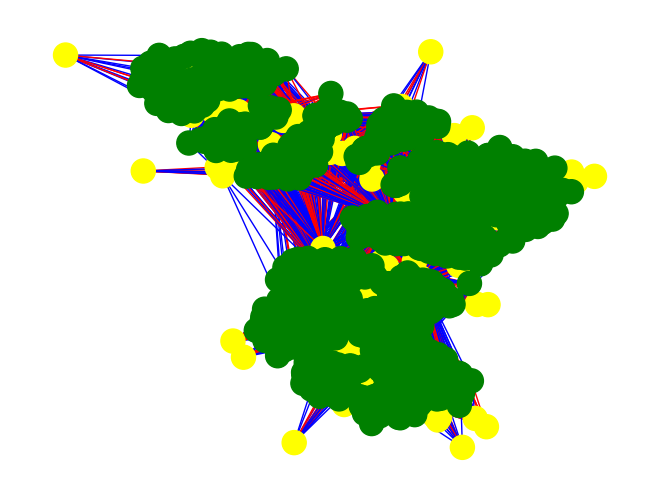

In [6]:
nx.draw(B, with_labels=False,node_color=colors,edge_color=edge_colors)
plt.show()

In [7]:
print(B.nodes(data=True))

[('set_a_0', {'bipartite': 0}), ('set_a_1', {'bipartite': 0}), ('set_a_2', {'bipartite': 0}), ('set_a_3', {'bipartite': 0}), ('set_a_4', {'bipartite': 0}), ('set_a_5', {'bipartite': 0}), ('set_a_6', {'bipartite': 0}), ('set_a_7', {'bipartite': 0}), ('set_a_8', {'bipartite': 0}), ('set_a_9', {'bipartite': 0}), ('set_a_10', {'bipartite': 0}), ('set_a_11', {'bipartite': 0}), ('set_a_12', {'bipartite': 0}), ('set_a_13', {'bipartite': 0}), ('set_a_14', {'bipartite': 0}), ('set_a_15', {'bipartite': 0}), ('set_a_16', {'bipartite': 0}), ('set_a_17', {'bipartite': 0}), ('set_a_18', {'bipartite': 0}), ('set_a_19', {'bipartite': 0}), ('set_a_20', {'bipartite': 0}), ('set_a_21', {'bipartite': 0}), ('set_a_22', {'bipartite': 0}), ('set_a_23', {'bipartite': 0}), ('set_a_24', {'bipartite': 0}), ('set_a_25', {'bipartite': 0}), ('set_a_26', {'bipartite': 0}), ('set_a_27', {'bipartite': 0}), ('set_a_28', {'bipartite': 0}), ('set_a_29', {'bipartite': 0}), ('set_a_30', {'bipartite': 0}), ('set_a_31', {'bi

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob=0.4):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)   # Fully connected layer
        self.dropout = nn.Dropout(p=dropout_prob)    # Dropout layer
        self.output_layer = nn.Linear(output_dim, output_dim)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))    # Apply ReLU activation to the fully connected layer
        x = self.dropout(x)        # Apply dropout to the output of the fully connected layer
        x = self.output_layer(x)   # Output layer, no activation function
        return x

In [10]:
class SBGNN(nn.Module):
    def __init__(self, graph, emb_dim_a=32, emb_dim_b=32):
        super(SBGNN, self).__init__()

        self.graph = graph
        self.set_a = [n for n, d in self.graph.nodes(data=True) if d['bipartite'] == 0]
        self.set_b = [n for n, d in self.graph.nodes(data=True) if d['bipartite'] == 1]
        self.emb_dim_a = emb_dim_a
        self.emb_dim_b = emb_dim_b

        # Initialize ModuleDict for features_a and features_b
        self.features_a = nn.ModuleDict({str(node): nn.Embedding(1, self.emb_dim_a) for node in self.set_a})
        self.features_b = nn.ModuleDict({str(node): nn.Embedding(1, self.emb_dim_b) for node in self.set_b})

        self.weight_a_b = nn.Parameter(torch.randn(self.emb_dim_a, self.emb_dim_a))
        self.weight_a_u = nn.Parameter(torch.randn(self.emb_dim_a, self.emb_dim_a))
        self.weight_b_b = nn.Parameter(torch.randn(self.emb_dim_b, self.emb_dim_b))
        self.weight_b_u = nn.Parameter(torch.randn(self.emb_dim_b, self.emb_dim_b))

        self.mlp_a = MLP(3 * self.emb_dim_a, self.emb_dim_a)
        self.mlp_b = MLP(3 * self.emb_dim_b, self.emb_dim_b)

    def message_passing(self, iterations=1):
        for i in range(iterations):
            new_features_a = {}
            new_features_b = {}

            for node in self.set_a:
                new_features_a_b = torch.zeros(self.emb_dim_a)
                new_features_a_u = torch.zeros(self.emb_dim_a)
                count_b = 0
                count_u = 0

                for neighbor in self.graph.neighbors(node):
                        sign = self.graph.edges[node, neighbor]['sign']
                        if sign == '+1':
                            new_features_a_b += self.features_b[str(neighbor)].weight.squeeze(0)
                            count_b += 1
                        else:
                            new_features_a_u += self.features_b[str(neighbor)].weight.squeeze(0)
                            count_u += 1

                if count_b > 0:
                    new_features_a_b /= count_b
                    new_features_a_b = torch.matmul(new_features_a_b, self.weight_a_b)

                if count_u > 0:
                    new_features_a_u /= count_u
                    new_features_a_u = torch.matmul(new_features_a_u, self.weight_a_u)

                new_features_a[str(node)] = torch.cat((new_features_a_b, new_features_a_u, self.features_a[str(node)].weight.squeeze(0)), dim=0)
                new_features_a[str(node)] = self.mlp_a(new_features_a[str(node)])

            for node in self.set_b:
                new_features_b_b = torch.zeros(self.emb_dim_b)
                new_features_b_u = torch.zeros(self.emb_dim_b)
                count_b = 0
                count_u = 0

                for neighbor in self.graph.neighbors(node):
                        sign = self.graph.edges[node, neighbor]['sign']
                        if sign == '+1':
                            new_features_b_b += self.features_a[str(neighbor)].weight.squeeze(0)
                            count_b += 1
                        else:
                            new_features_b_u += self.features_a[str(neighbor)].weight.squeeze(0)
                            count_u += 1

                if count_b > 0:
                    new_features_b_b /= count_b
                    new_features_b_b = torch.matmul(new_features_b_b, self.weight_b_b)

                if count_u > 0:
                    new_features_b_u /= count_u
                    new_features_b_u = torch.matmul(new_features_b_u, self.weight_b_u)

                new_features_b[str(node)] = torch.cat((new_features_b_b, new_features_b_u, self.features_b[str(node)].weight.squeeze(0)), dim=0)
                new_features_b[str(node)] = self.mlp_b(new_features_b[str(node)])

            # Update ModuleDicts
            for node in self.set_a:
                self.features_a[str(node)].weight = nn.Parameter(new_features_a[str(node)].unsqueeze(0))

            for node in self.set_b:
                self.features_b[str(node)].weight = nn.Parameter(new_features_b[str(node)].unsqueeze(0))

    


In [11]:
sbgnn = SBGNN(B)
print(sbgnn.features_a["set_a_0"].weight.squeeze(0))
sbgnn.message_passing(iterations=4)


tensor([-0.4768,  2.2853,  0.6837,  1.5812,  1.6032,  0.6156,  0.1191,  1.0011,
        -1.2580,  0.5724,  0.9799, -0.9433,  0.0770,  0.2949,  0.6046, -0.9263,
         0.1596,  2.0887, -0.9970, -1.1601,  0.1253,  0.7967,  0.4937,  0.7317,
        -0.2345,  0.1952,  0.3659, -1.0667,  1.6647,  1.1855, -0.7469, -0.3878],
       grad_fn=<SqueezeBackward1>)


In [12]:
print(sbgnn.features_a["set_a_0"].weight.squeeze(0))

tensor([-0.1376, -0.1427, -0.1164,  0.0115,  0.0581,  0.1345, -0.0448, -0.0310,
        -0.0661,  0.0373,  0.0754, -0.0468,  0.0906, -0.1494,  0.1532, -0.0789,
        -0.0311, -0.0841,  0.1259,  0.0201,  0.2416,  0.2569, -0.0520,  0.1329,
        -0.4124,  0.1023, -0.0336, -0.1814, -0.1679, -0.4540, -0.0167,  0.1592],
       grad_fn=<SqueezeBackward1>)


In [13]:
C_a=torch.zeros(1,32)
C_b=torch.ones(1,32)
list_a=[C_a,C_b]
stacked_tensor = torch.stack(list_a, dim=1).squeeze(0)
print(stacked_tensor)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [14]:
class Softmax(nn.Module):
    def __init__(self, input_dim, cluster_number):
        super(Softmax, self).__init__()
        self.fc = nn.Linear(input_dim, cluster_number)  # Fully connected layer

    def forward(self, x):
        x = self.fc(x)         # Apply the fully connected layer
        x = F.softmax(x, dim=0)  # Apply softmax to the output
        return x


In [78]:
class Community(nn.Module):
    def __init__(self, sbgnn, cluster_number):
        super(Community, self).__init__()
        
        self.sbgnn=sbgnn
        self.cluster_number=cluster_number
        self.emb_dim_a=self.sbgnn.emb_dim_a
        self.emb_dim_b=self.sbgnn.emb_dim_b

        self.Softmax_a=Softmax(self.emb_dim_a,self.cluster_number)
        self.Softmax_b=Softmax(self.emb_dim_b,self.cluster_number)


    def build_communities(self):
        self.list_a=[]
        self.list_b=[]
        
        for node in sbgnn.set_a:
            new_tensor=sbgnn.features_a[str(node)].weight.squeeze(0)
            new_tensor=self.Softmax_a(new_tensor)
            self.list_a.append(new_tensor)
        
        self.C_a=torch.stack(self.list_a,dim=1).squeeze(0)
        self.C_a=self.C_a.to(dtype=torch.float64)


        for node in sbgnn.set_b:
            new_tensor=sbgnn.features_b[str(node)].weight.squeeze(0)
            new_tensor=self.Softmax_b(new_tensor)
            self.list_b.append(new_tensor)
        
        self.C_b=torch.stack(self.list_b,dim=1).squeeze(0)
        self.C_b=self.C_b.to(dtype=torch.float64)

In [79]:
comm=Community(sbgnn,5)
comm.build_communities()

In [80]:
print(comm.C_a.shape)
print(comm.C_b.shape)

torch.Size([5, 145])
torch.Size([5, 1056])


In [81]:
print(B.edges(data=True))

[('set_a_0', 'set_b_727', {'sign': '+1'}), ('set_a_0', 'set_b_728', {'sign': '+1'}), ('set_a_0', 'set_b_734', {'sign': '+1'}), ('set_a_0', 'set_b_735', {'sign': '+1'}), ('set_a_0', 'set_b_736', {'sign': '-1'}), ('set_a_0', 'set_b_737', {'sign': '+1'}), ('set_a_0', 'set_b_738', {'sign': '+1'}), ('set_a_0', 'set_b_739', {'sign': '+1'}), ('set_a_0', 'set_b_743', {'sign': '+1'}), ('set_a_0', 'set_b_757', {'sign': '+1'}), ('set_a_0', 'set_b_765', {'sign': '+1'}), ('set_a_0', 'set_b_776', {'sign': '-1'}), ('set_a_0', 'set_b_781', {'sign': '-1'}), ('set_a_0', 'set_b_782', {'sign': '+1'}), ('set_a_0', 'set_b_787', {'sign': '-1'}), ('set_a_0', 'set_b_794', {'sign': '-1'}), ('set_a_0', 'set_b_798', {'sign': '-1'}), ('set_a_0', 'set_b_801', {'sign': '+1'}), ('set_a_0', 'set_b_809', {'sign': '-1'}), ('set_a_0', 'set_b_820', {'sign': '+1'}), ('set_a_1', 'set_b_420', {'sign': '-1'}), ('set_a_1', 'set_b_421', {'sign': '-1'}), ('set_a_1', 'set_b_422', {'sign': '+1'}), ('set_a_1', 'set_b_423', {'sign':

In [82]:
G = nx.Graph()

# Add edges with weights (positive or negative)
G.add_edge(1, 2, weight=1)
G.add_edge(1, 3, weight=-1)
G.add_edge(2, 3, weight=1)
G.add_edge(3, 4, weight=-1)
G.add_edge(4, 5, weight=1)

adj=nx.adjacency_matrix(G).todense()
adj_tensor=torch.tensor(adj,dtype=torch.float32)

print(adj)


[[ 0  1 -1  0  0]
 [ 1  0  1  0  0]
 [-1  1  0 -1  0]
 [ 0  0 -1  0  1]
 [ 0  0  0  1  0]]


In [83]:
total_positive=0
for u, v, data in G.edges(data=True):
    if data['weight'] > 0:
        total_positive+=1

print(total_positive)

3


In [84]:
for node_i in G.nodes():
    for node_j in G.nodes():
        print(node_i,node_j)
    print()

1 1
1 2
1 3
1 4
1 5

2 1
2 2
2 3
2 4
2 5

3 1
3 2
3 3
3 4
3 5

4 1
4 2
4 3
4 4
4 5

5 1
5 2
5 3
5 4
5 5



In [85]:
temp_list=[1,2,3]
fin_list=[]
for i in range(3):
    fin_list.append(temp_list)
fin_list=np.matrix(fin_list)
cop_list=fin_list
print(cop_list-fin_list)

[[0 0 0]
 [0 0 0]
 [0 0 0]]


In [92]:
class Modularity(nn.Module):
    def __init__(self,sbgnn,community):
        super(Modularity, self).__init__()

        self.graph=sbgnn.graph
        self.set_a = sbgnn.set_a
        self.set_b = sbgnn.set_b
        self.n=len(set_a)
        self.m=len(set_b)

        self.community=community
        self.C_a=self.community.C_a
        self.C_b=self.community.C_b

        self.positive_counts={node:0 for node in self.graph.nodes()}
        self.negative_counts={node:0 for node in self.graph.nodes()}
        self.total_positive=0
        self.total_negative=0


    def build_adjacency_matrix(self):
        matrix = np.zeros((self.n, self.m))
        for i, a_node in enumerate(self.set_a):
            for j, b_node in enumerate(self.set_b):
                if self.graph.has_edge(a_node, b_node) and self.graph[a_node][b_node]['sign']=='+1':
                    matrix[i, j] = 1
                elif self.graph.has_edge(a_node, b_node) and self.graph[a_node][b_node]['sign']=='-1':
                    matrix[i,j] = -1
        self.adj_matrix=matrix


    def count_edges(self):
        for u, v, data in self.graph.edges(data=True):
            if data['sign'] =='+1':
                self.positive_counts[u] += 1
                self.positive_counts[v] += 1
                self.total_positive+=1
            elif data['sign'] =='-1':
                self.negative_counts[u] += 1
                self.negative_counts[v] += 1
                self.total_negative+=1
        
        self.positive_plus_negative=self.total_positive+self.total_negative
    
    def build_W_matrix(self):
        matrix=[]
        for node_i in self.set_a:
            temp_list=[]
            for node_j in self.set_b:
                pos=(self.positive_counts[node_i]*self.positive_counts[node_j])/self.total_positive
                neg=(self.negative_counts[node_i]*self.negative_counts[node_j])/self.total_negative
                temp_list.append(pos-neg)
            matrix.append(temp_list)
        matrix=np.matrix(matrix)
        matrix=self.adj_matrix-matrix
        self.W_matrix=torch.from_numpy(matrix)

    def find_modularity(self):
        denominator=1/self.positive_plus_negative
        final_matrix= torch.matmul(self.C_a,self.W_matrix)
        self.final_matrix=torch.matmul(final_matrix,self.C_b.t())
        self.trace=torch.trace(self.final_matrix)
        self.modularity=denominator*self.trace

In [93]:
inst=Modularity(sbgnn,comm)
inst.count_edges()

inst.build_adjacency_matrix()

inst.build_W_matrix()

inst.find_modularity()

In [94]:
print(inst.modularity)

tensor(-1.8919e-05, dtype=torch.float64, grad_fn=<MulBackward0>)
